In [1]:
%matplotlib ipympl

# Example of monophasic propagation block

In [2]:
from cajal.nrn import Backend as N
from cajal.nrn.cells import MRG
from cajal.units import mm, um, mV, ms

N.dt = 0.005*ms #The default one

# Set diameter and length
diameter = 27 * um
length = 40 * mm

# Create the axon without specifying axonnodes
mrg = MRG(diameter=diameter, length=length, v_init=-80.0 * mV)

# Get the total number of nodes
print(f"Computed number of Nodes: {len(mrg.node)}")

# Calculate total length based on node positions
first_node_y = mrg.node[0].y3d(0)
last_node_y = mrg.node[-1].y3d(0)
total_length = (last_node_y - first_node_y) / 1000  

print(f"Computed Axon Length: {total_length:.2f} mm")

for node in [mrg.node[0], mrg.node[-1]]:
    x = node.x3d(0) / 1000  # Convert to mm
    y = node.y3d(0) / 1000
    z = node.z3d(0) / 1000
    print(f"Node x={x:.2f} mm, y={y:.2f} mm, z={z:.2f} mm")

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


Computed number of Nodes: 68
Computed Axon Length: 39.27 mm
Node x=0.00 mm, y=-19.64 mm, z=0.00 mm
Node x=0.00 mm, y=19.64 mm, z=0.00 mm


In [3]:
from cajal.nrn.stimuli import MonophasicPulse
from cajal.nrn.sources import IsotropicPoint
from cajal.units import mA, ms, ohm, cm
from cajal.nrn.monitors import StateMonitor, APMonitor
from cajal.nrn import SimulationEnvironment

# Setup a default (fixed) stimulation values 
stim_amp = -0.2 * mA
stim_pw = 0.05 * ms
stim_delay = 2.5 * ms

# Define blocking parameters
block_amp = 0.8 * mA 
block_pw = 0.5 * ms 
block_delay = 0.1 * ms 

# Create stimuli
stim = MonophasicPulse(amp=stim_amp, pw=stim_pw, delay=stim_delay)
block = MonophasicPulse(amp=block_amp, pw=block_pw, delay=block_delay)

# Create electrodes at both ends (set spacing of 6 mm)
pointsource_stim = IsotropicPoint(x=0 * mm, y=-10 * mm, z=1 * mm, rhoe=500 * ohm * cm)
pointsource_block = IsotropicPoint(x=0 * mm, y=10 * mm, z=1 * mm, rhoe=500 * ohm * cm)

# Assign stimuli to electrodes
electrode_stim = pointsource_stim << stim
electrode_block = pointsource_block << block

# Set up monitors
ap_monitor_end = APMonitor(mrg.node[-10], threshold= -20 * mV)
ap_monitor_start = APMonitor(mrg.node[10], threshold= -20 * mV)
v_rec = StateMonitor(mrg.node, "v")

# Create the simulation environment
env = SimulationEnvironment(
    axons=[mrg],
    extra_stim=[electrode_stim],
    monitors=[v_rec, ap_monitor_end, ap_monitor_start]
)

# Run the simulation for a sufficient duration to observe AP propagation
env.run(6 * ms, early_stopping=False)

ap_count_end = ap_monitor_end.n(t=0.14 * ms)
print(f"Number of APs after 0.14 ms at end node: {ap_count_end}")

ap_times_end = ap_monitor_end.spikes()
print(f"All spike times at end node: {ap_times_end}")

ap_times_start = ap_monitor_start.spikes()
print(f"All spike times at start node: {ap_times_start}")

if ap_count_end == 1:
    print("AP NOT blocked")
else:
    print("AP is blocked")

5.5 ms: 100%|██████████| 1200/1200 [00:00<00:00, 1939.34it/s]


Number of APs after 0.14 ms at end node: 1
All spike times at end node: [2.855]
All spike times at start node: [2.63]
AP NOT blocked


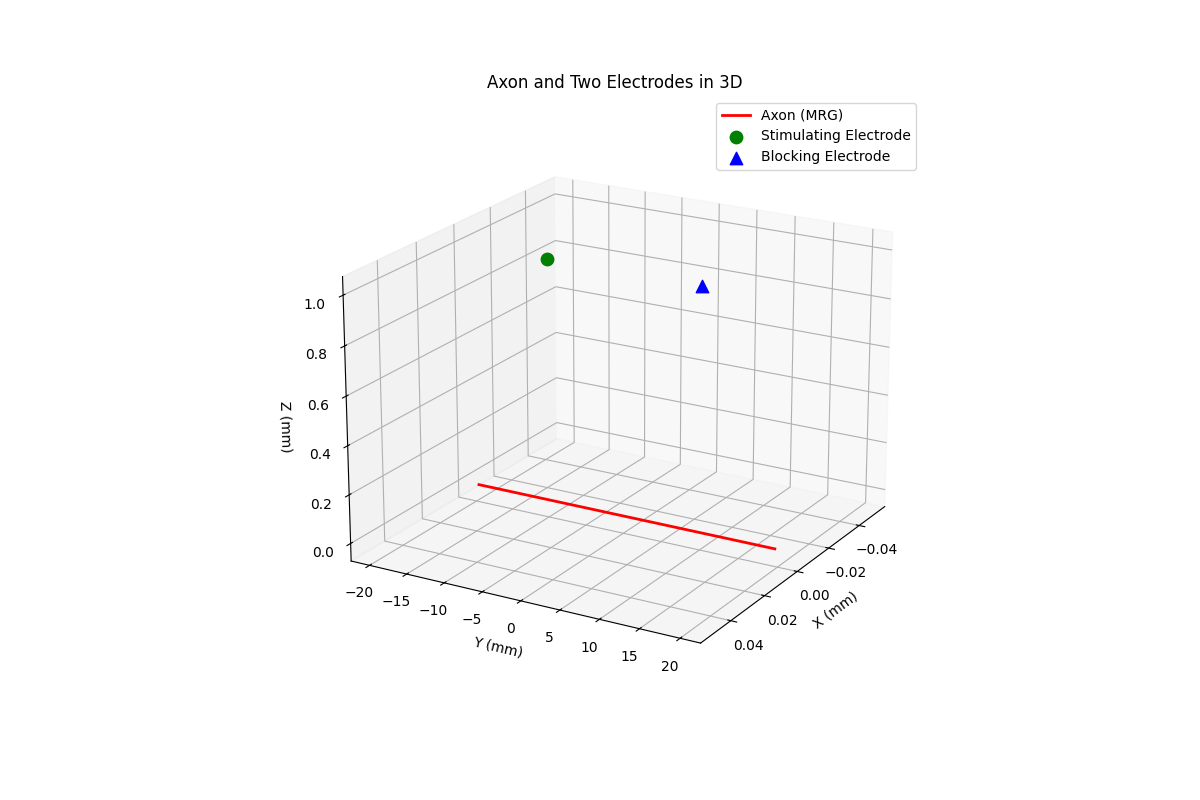

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Extract node positions
node_x = np.array([n.x3d(0) for n in mrg.node]) / 1000.0 
node_y = np.array([n.y3d(0) for n in mrg.node]) / 1000.0
node_z = np.array([n.z3d(0) for n in mrg.node]) / 1000.0

start_ele_x = pointsource_stim.x.value / 1000.0
start_ele_y = pointsource_stim.y.value / 1000.0
start_ele_z = pointsource_stim.z.value / 1000.0

end_ele_x = pointsource_block.x.value / 1000.0
end_ele_y = pointsource_block.y.value / 1000.0
end_ele_z = pointsource_block.z.value / 1000.0

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the axon
ax.plot(node_x, node_y, node_z, color='red', label='Axon (MRG)', linewidth=2)

# Plot electrodes
ax.scatter(start_ele_x, start_ele_y, start_ele_z, color='green', s=80, marker='o', label='Stimulating Electrode')
ax.scatter(end_ele_x, end_ele_y, end_ele_z, color='blue', s=80, marker='^', label='Blocking Electrode')

ax.set_xlabel('X (mm)')
ax.set_ylabel('Y (mm)')
ax.set_zlabel('Z (mm)')
ax.view_init(elev=20, azim=30)

plt.title('Axon and Two Electrodes in 3D')
plt.legend()
plt.show()

In [16]:
def plot_progression_AP_3D(mrg, v_rec, pw, amp, delay):
    V = v_rec.v
    t = v_rec.t  # This gives you all time points recorded

    # Convert time to ms for plotting
    T = t / ms

    # Create meshgrids for node numbers and time steps
    nodes = np.arange(mrg.axonnodes)
    T_2D, N_2D = np.meshgrid(T, nodes, indexing='ij')  # shape (#time_steps, #nodes)
    V_t = V.T

    # Define desired membrane potential limits
    vmin = -120
    vmax = 70

    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111, projection='3d')

    surf = ax.plot_surface(N_2D, T_2D, V_t, cmap='jet', edgecolor='none', alpha=0.8,
                           vmin=vmin, vmax=vmax)

    ax.set_zlim(vmin, vmax)
    ax.set_xlabel('Node Number')
    ax.set_ylabel('Time (ms)')
    ax.set_zlabel('Membrane Potential (mV)')
    ax.set_title(f"AP Progression PW={pw}, Amp={amp} and Delay={delay}")

    fig.colorbar(surf, shrink=0.5, aspect=10, label='Membrane Potential (mV)')

    plt.tight_layout()
    plt.show()

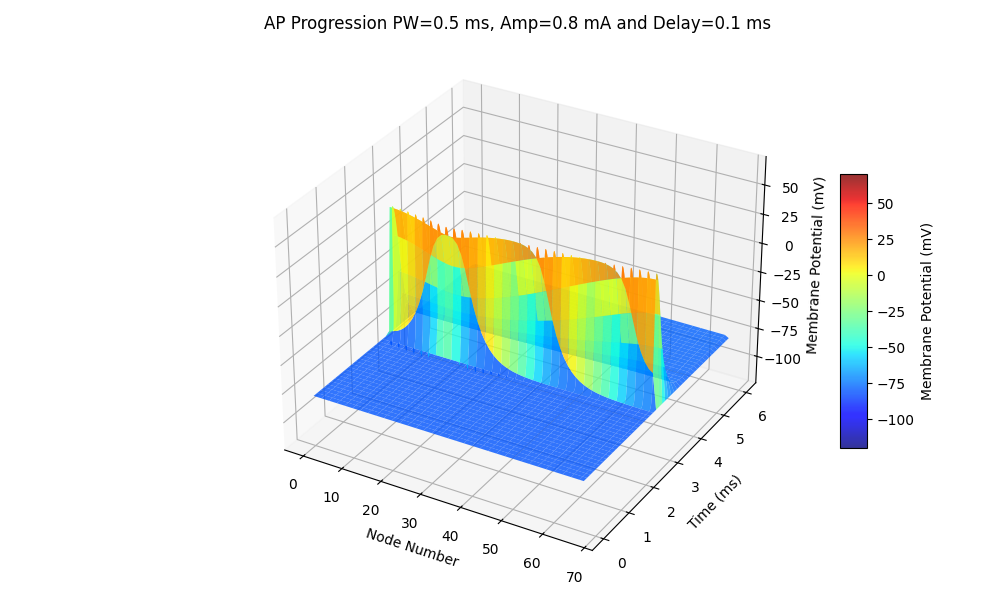

In [17]:
plot_progression_AP_3D(mrg, v_rec, block_pw, block_amp, block_delay)

plt.close(fig)  

In [18]:
import numpy as np
from matplotlib.animation import FuncAnimation
from cajal.units import ms

def plot_progression_AP_animated_full(mrg, v_rec, pw, amp):
    # Use the entire recorded time array
    t = v_rec.t  # shape: (time_steps,)
    # v_rec.v: shape (axonnodes, time_steps)

    fig, ax = plt.subplots(figsize=(10, 5))

    # Create a line object that will be updated for each time step
    line, = ax.plot([], [], lw=2)
    
    # Set plot limits and labels
    ax.set_xlim(0, mrg.axonnodes)
    ax.set_ylim(-160, 60)
    ax.set_xlabel('Node Number')
    ax.set_ylabel('Membrane Potential (mV)')
    ax.grid(True)

    # We'll update the title to show the current time
    title_text = ax.set_title("")

    def init():
        line.set_data([], [])
        return line, title_text

    def update(frame):
        # Update function called at each frame
        x_data = np.arange(mrg.axonnodes)
        y_data = v_rec.v[:, frame]
        current_t = t[frame]

        line.set_data(x_data, y_data)
        #title_text.set_text(f"Time: {current_t:.2f} ms | PW={pw}, Amp={amp}")
        title_text.set_text(f"Time: {current_t:.2f} ms | Stimulation PW={pw}, Amp={amp}")
        if current_t >= 1.5:  # Stop after 5 ms
            ani.event_source.stop()

        return line, title_text

    ani = FuncAnimation(fig, update, frames=len(t), init_func=init, blit=True, interval=5)

    ani.save('nerve_blocking.gif', writer='pillow', fps=50)

    return ani, fig


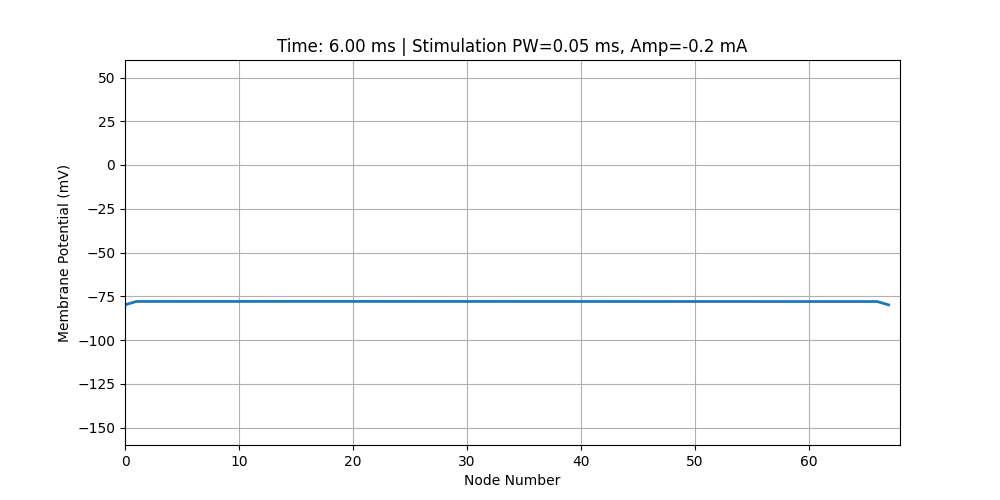

In [19]:
#ani, fig = plot_progression_AP_animated_full(mrg, v_rec, block_pw, block_amp)
ani, fig = plot_progression_AP_animated_full(mrg, v_rec, stim_pw, stim_amp)
plt.show()

In [20]:
def plot_progression_AP(mrg, v_rec, pw, amp):

    time_points = np.arange(0.11 * ms, 2.0 * ms, 0.1 * ms)
    # Convert time to indices the default sampling of v_rc.t is 0.005 ms
    time_indices = [int(t / (0.005 * ms)) for t in time_points]  

    # Create a figure with 4 rows and 3 columns of subplots
    fig, axes = plt.subplots(6, 3, figsize=(15, 10))

    # Iterate over the axes and time points to plot data
    for ax, t_idx, t in zip(axes.flatten(), time_indices, time_points):
        ax.plot(range(mrg.axonnodes), v_rec.v[:, t_idx])
        ax.set_title(f'Time: {t:.2f} ms')
        ax.set_xlabel('Node Number')
        ax.set_ylabel('Membrane Potential (mV)')
        ax.set_ylim(-160, 60)  # Set y-axis range
        ax.grid(True)

    # Adjust layout to prevent overlapping text and plots
    plt.tight_layout()
    plt.suptitle(f"Potential Progression using a Blocking Pulse Width {pw} and Amp {amp} ", fontsize=16, y=1.02)
    plt.show()

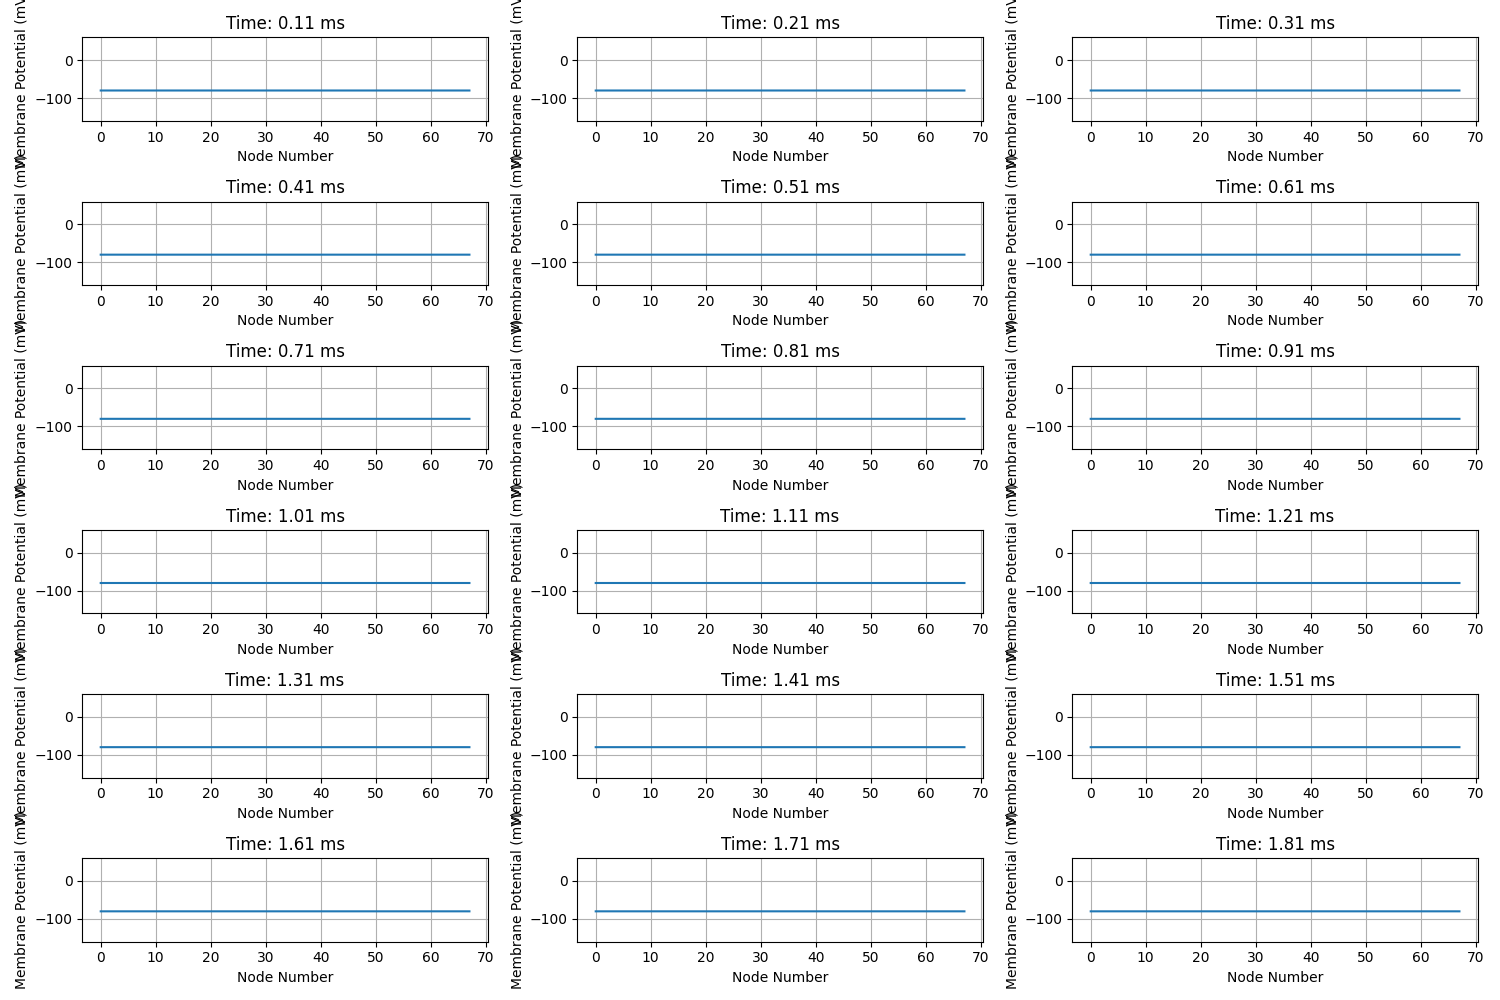

In [21]:
plot_progression_AP(mrg, v_rec, block_pw, block_amp) 

In [ ]:
from typing import Mapping
import tensorflow as tf
from functools import partial

from online_neuro.bayessian_optimizer import BayesianOptimizer, AskTellOptimizerHistory
from online_neuro.online_learning import build_model
from online_neuro.utils import CustomMinMaxScaler, SearchSpacePipeline

from simulators.python.problems.toy_problems import circle, multiple_circles

import trieste
from trieste.data import Dataset
from trieste.acquisition.function import BayesianActiveLearningByDisagreement
from trieste.acquisition.rule import EfficientGlobalOptimization
from trieste.bayesian_optimizer import Record
from trieste.observer import OBJECTIVE
from trieste import space
from trieste.ask_tell_optimization import AskTellOptimizer, AskTellOptimizerNoTraining


2025-01-17 17:47:33.595113: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-01-17 17:47:33.596155: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [59]:
def run_simulation(block_amp, block_pw, block_delay):
    """
    Run the AP blocking simulation with given stimulus parameters.
    
    Parameters:
    - stim_amp_end: Amplitude of the second stimulus (mA)
    - stim_delay_end: Delay of the second stimulus (ms)
    
    Returns:
    - ap_count: Number of action potentials reaching the end of the axon.
    """
    # Set desired diameter and length
    diameter = 27 * um
    length = 60 * mm

    # Create the axon without specifying axonnodes
    mrg = MRG(diameter=diameter, length=length, v_init=-80.0 * mV)

    print(f"Configuration: Amplitude {block_amp:.2f} mA, pulse width {block_pw:.2f} ms, delay {block_delay:.2f}")

    # Setup a default (fixed) stimulation values 
    stim_amp = -0.2 * mA
    stim_pw = 0.05 * ms
    stim_delay = 2.5 * ms

    # Create stimuli
    stim = MonophasicPulse(amp=stim_amp, pw=stim_pw, delay=stim_delay)
    block = MonophasicPulse(amp=block_amp, pw=block_pw, delay=block_delay)

    # Create electrodes at both ends (set spacing of 6 mm)
    pointsource_stim = IsotropicPoint(x=0 * mm, y=-10 * mm, z=1 * mm, rhoe=500 * ohm * cm)
    pointsource_block = IsotropicPoint(x=0 * mm, y=10 * mm, z=1 * mm, rhoe=500 * ohm * cm)

    # Assign stimuli to electrodes
    electrode_stim = pointsource_stim << stim
    electrode_block = pointsource_block << block

    # Set up monitors
    ap_monitor_end = APMonitor(mrg.node[-10], threshold= -20 * mV)
    ap_monitor_start = APMonitor(mrg.node[10], threshold= -20 * mV)
    v_rec = StateMonitor(mrg.node, "v")

    # Create the simulation environment
    env = SimulationEnvironment(
        axons=[mrg],
        extra_stim=[electrode_stim, electrode_block],
        monitors=[v_rec, ap_monitor_end, ap_monitor_start]
    )

    # Run the simulation for a sufficient duration to observe AP propagation
    env.run(5 * ms, early_stopping=False)

    ap_count_end = ap_monitor_end.n(t=2.50 * ms)
    print(f"Number of APs after 2.50 ms at end node: {ap_count_end}")

    start_time = 2.50 * ms
    end_time = 3.10 * ms

    # Calculate the number of APs between start_time and end_time at the start node
    ap_count_start_end = ap_monitor_start.n(t=end_time)
    ap_count_start_start = ap_monitor_start.n(t=start_time)
    ap_count_left = ap_count_start_start - ap_count_start_end # Never less than zero
    print(f"Number of APs between {start_time} and {end_time} ms at start node: {ap_count_left}")

    ap_times_end = ap_monitor_end.spikes()
    print(f"All spike times at end node: {ap_times_end}")
    
    if ap_count_end > 0:
        print("AP NOT blocked")
        return 1
    else:
        if ap_count_left == 0:
            print('NO AP at the left side')
            return 1
        else:
            print("AP is blocked")
            return 0


In [ ]:
def ap_blocking_objective(params):
    """
    Objective function to optimize AP blocking
    """
    stim_amp, stim_pw, stim_delay = params[:, 0], params[:, 1], params[:, 2]
    
    observations = []
    
    for amp, pw, delay in zip(stim_amp, stim_pw, stim_delay):
        # Run the simulation with given parameters
        try:
            # Run the simulation and get the AP observation
            ap_count = run_simulation(amp, pw, delay)
            observations.append(ap_count)

        except Exception as e:
            print(f"Simulation failed with amp={amp}, pulse width={pw}, delay={delay}: {e}")
            observations.append(np.nan)  

    return np.array(observations).reshape(-1, 1)


In [66]:
# Define parameter bounds
lb = [-4.00, 0.05, 0.10]  # Lower bounds for [stim_amp, stim_pw, stim_delay]
ub = [4.00, 3.50, 2.00]  # Upper bounds

# Initialize scaler
scaler = CustomMinMaxScaler(feature_min=lb, feature_max=ub, output_range=(-1, 1))

# Define search space
search_space = space.Box(lower=[-1, -1, -1], upper=[1, 1, 1])

# Generate initial samples
init_samples = 40
qp_minmax = search_space.sample(init_samples).numpy()
qp = scaler.inverse_transform(qp_minmax)

observations = ap_blocking_objective(qp)

Configuration: Amplitude 1.71 mA, pulse width 1.08 ms, delay 0.60


4.5 ms: 100%|██████████| 1000/1000 [00:03<00:00, 330.18it/s]


Number of APs after 2.50 ms at end node: 0
Number of APs between 2.5 ms and 3.1 ms ms at start node: 0
All spike times at end node: [0.705]
NO AP at the left side
Configuration: Amplitude 0.38 mA, pulse width 2.64 ms, delay 0.43


4.5 ms: 100%|██████████| 1000/1000 [00:02<00:00, 371.87it/s]


Number of APs after 2.50 ms at end node: 1
Number of APs between 2.5 ms and 3.1 ms ms at start node: 1
All spike times at end node: [0.74  3.085]
AP NOT blocked
Configuration: Amplitude 1.32 mA, pulse width 2.30 ms, delay 0.48


4.5 ms: 100%|██████████| 1000/1000 [00:02<00:00, 347.76it/s]


Number of APs after 2.50 ms at end node: 0
Number of APs between 2.5 ms and 3.1 ms ms at start node: 1
All spike times at end node: [0.605]
AP is blocked
Configuration: Amplitude -0.97 mA, pulse width 1.51 ms, delay 0.38


4.5 ms: 100%|██████████| 1000/1000 [00:02<00:00, 334.19it/s]


Number of APs after 2.50 ms at end node: 0
Number of APs between 2.5 ms and 3.1 ms ms at start node: 0
All spike times at end node: [0.825]
NO AP at the left side
Configuration: Amplitude -2.50 mA, pulse width 1.23 ms, delay 0.99


4.5 ms: 100%|██████████| 1000/1000 [00:03<00:00, 313.23it/s]


Number of APs after 2.50 ms at end node: 0
Number of APs between 2.5 ms and 3.1 ms ms at start node: 1
All spike times at end node: [2.44]
AP is blocked
Configuration: Amplitude -2.76 mA, pulse width 1.11 ms, delay 0.48


4.5 ms: 100%|██████████| 1000/1000 [00:02<00:00, 381.49it/s]


Number of APs after 2.50 ms at end node: 0
Number of APs between 2.5 ms and 3.1 ms ms at start node: 0
All spike times at end node: [1.81]
NO AP at the left side
Configuration: Amplitude 1.51 mA, pulse width 3.37 ms, delay 0.29


4.5 ms: 100%|██████████| 1000/1000 [00:03<00:00, 312.64it/s]


Number of APs after 2.50 ms at end node: 0
Number of APs between 2.5 ms and 3.1 ms ms at start node: 1
All spike times at end node: [0.4]
AP is blocked
Configuration: Amplitude -2.08 mA, pulse width 1.79 ms, delay 0.37


4.5 ms: 100%|██████████| 1000/1000 [00:04<00:00, 206.00it/s]


Number of APs after 2.50 ms at end node: 0
Number of APs between 2.5 ms and 3.1 ms ms at start node: 1
All spike times at end node: [2.445]
AP is blocked
Configuration: Amplitude -1.13 mA, pulse width 1.55 ms, delay 0.63


4.5 ms: 100%|██████████| 1000/1000 [00:02<00:00, 334.81it/s]


Number of APs after 2.50 ms at end node: 0
Number of APs between 2.5 ms and 3.1 ms ms at start node: 0
All spike times at end node: [1.165]
NO AP at the left side
Configuration: Amplitude -3.15 mA, pulse width 1.49 ms, delay 0.91


4.5 ms: 100%|██████████| 1000/1000 [00:03<00:00, 272.27it/s]


Number of APs after 2.50 ms at end node: 1
Number of APs between 2.5 ms and 3.1 ms ms at start node: 1
All spike times at end node: [2.625]
AP NOT blocked
Configuration: Amplitude 0.04 mA, pulse width 1.88 ms, delay 0.91


4.5 ms: 100%|██████████| 1000/1000 [00:02<00:00, 349.88it/s]
2024-12-19 16:24:34,378 rank[0] [INFO] The pulse ends after the simulation end time.


Number of APs after 2.50 ms at end node: 1
Number of APs between 2.5 ms and 3.1 ms ms at start node: 1
All spike times at end node: [2.965]
AP NOT blocked
Configuration: Amplitude -0.45 mA, pulse width 3.36 ms, delay 1.81


4.5 ms: 100%|██████████| 1000/1000 [00:02<00:00, 341.86it/s]


Number of APs after 2.50 ms at end node: 0
Number of APs between 2.5 ms and 3.1 ms ms at start node: 0
All spike times at end node: [2.06]
NO AP at the left side
Configuration: Amplitude -1.60 mA, pulse width 3.26 ms, delay 0.47


4.5 ms: 100%|██████████| 1000/1000 [00:03<00:00, 308.19it/s]


Number of APs after 2.50 ms at end node: 0
Number of APs between 2.5 ms and 3.1 ms ms at start node: 0
All spike times at end node: [1.225]
NO AP at the left side
Configuration: Amplitude -3.05 mA, pulse width 0.48 ms, delay 1.26


4.5 ms: 100%|██████████| 1000/1000 [00:02<00:00, 381.54it/s]


Number of APs after 2.50 ms at end node: 0
Number of APs between 2.5 ms and 3.1 ms ms at start node: 0
All spike times at end node: [1.94]
NO AP at the left side
Configuration: Amplitude -2.69 mA, pulse width 2.84 ms, delay 1.63


4.5 ms: 100%|██████████| 1000/1000 [00:04<00:00, 227.40it/s]


Number of APs after 2.50 ms at end node: 1
Number of APs between 2.5 ms and 3.1 ms ms at start node: 0
All spike times at end node: [4.805]
AP NOT blocked
Configuration: Amplitude 3.06 mA, pulse width 2.70 ms, delay 0.28


4.5 ms: 100%|██████████| 1000/1000 [00:04<00:00, 240.36it/s]
2024-12-19 16:24:52,280 rank[0] [INFO] The pulse ends after the simulation end time.


Number of APs after 2.50 ms at end node: 0
Number of APs between 2.5 ms and 3.1 ms ms at start node: 1
All spike times at end node: [0.365]
AP is blocked
Configuration: Amplitude 0.55 mA, pulse width 3.43 ms, delay 1.94


4.5 ms: 100%|██████████| 1000/1000 [00:03<00:00, 254.49it/s]


Number of APs after 2.50 ms at end node: 1
Number of APs between 2.5 ms and 3.1 ms ms at start node: 0
All spike times at end node: [2.16 4.08]
AP NOT blocked
Configuration: Amplitude -0.37 mA, pulse width 1.35 ms, delay 1.13


4.5 ms: 100%|██████████| 1000/1000 [00:02<00:00, 405.41it/s]


Number of APs after 2.50 ms at end node: 0
Number of APs between 2.5 ms and 3.1 ms ms at start node: 0
All spike times at end node: [1.37]
NO AP at the left side
Configuration: Amplitude -0.32 mA, pulse width 1.27 ms, delay 1.42


4.5 ms: 100%|██████████| 1000/1000 [00:03<00:00, 280.26it/s]


Number of APs after 2.50 ms at end node: 0
Number of APs between 2.5 ms and 3.1 ms ms at start node: 0
All spike times at end node: [1.66]
NO AP at the left side
Configuration: Amplitude 0.62 mA, pulse width 3.10 ms, delay 1.88


4.5 ms: 100%|██████████| 1000/1000 [00:03<00:00, 265.68it/s]


Number of APs after 2.50 ms at end node: 1
Number of APs between 2.5 ms and 3.1 ms ms at start node: 0
All spike times at end node: [2.075 3.92 ]
AP NOT blocked
Configuration: Amplitude -3.29 mA, pulse width 2.42 ms, delay 1.07


4.5 ms: 100%|██████████| 1000/1000 [00:05<00:00, 193.39it/s]


Number of APs after 2.50 ms at end node: 1
Number of APs between 2.5 ms and 3.1 ms ms at start node: 0
All spike times at end node: [3.74]
AP NOT blocked
Configuration: Amplitude -0.94 mA, pulse width 2.76 ms, delay 1.56


4.5 ms: 100%|██████████| 1000/1000 [00:04<00:00, 202.82it/s]


Number of APs after 2.50 ms at end node: 0
Number of APs between 2.5 ms and 3.1 ms ms at start node: 0
All spike times at end node: [1.99]
NO AP at the left side
Configuration: Amplitude -0.92 mA, pulse width 0.37 ms, delay 0.91


4.5 ms: 100%|██████████| 1000/1000 [00:04<00:00, 240.16it/s]


Number of APs after 2.50 ms at end node: 0
Number of APs between 2.5 ms and 3.1 ms ms at start node: 0
All spike times at end node: [1.32]
NO AP at the left side
Configuration: Amplitude 3.24 mA, pulse width 0.71 ms, delay 0.62


4.5 ms: 100%|██████████| 1000/1000 [00:09<00:00, 110.54it/s]


Number of APs after 2.50 ms at end node: 0
Number of APs between 2.5 ms and 3.1 ms ms at start node: 0
All spike times at end node: [0.7]
NO AP at the left side
Configuration: Amplitude 1.22 mA, pulse width 3.02 ms, delay 0.62


4.5 ms: 100%|██████████| 1000/1000 [00:05<00:00, 198.79it/s]


Number of APs after 2.50 ms at end node: 0
Number of APs between 2.5 ms and 3.1 ms ms at start node: 1
All spike times at end node: [0.745]
AP is blocked
Configuration: Amplitude -3.49 mA, pulse width 2.52 ms, delay 1.34


4.5 ms: 100%|██████████| 1000/1000 [00:02<00:00, 372.10it/s]


Number of APs after 2.50 ms at end node: 1
Number of APs between 2.5 ms and 3.1 ms ms at start node: 0
All spike times at end node: [4.12]
AP NOT blocked
Configuration: Amplitude 1.58 mA, pulse width 2.42 ms, delay 1.45


4.5 ms: 100%|██████████| 1000/1000 [00:02<00:00, 419.77it/s]


Number of APs after 2.50 ms at end node: 0
Number of APs between 2.5 ms and 3.1 ms ms at start node: 0
All spike times at end node: [1.565]
NO AP at the left side
Configuration: Amplitude -2.79 mA, pulse width 0.61 ms, delay 1.50


4.5 ms: 100%|██████████| 1000/1000 [00:03<00:00, 256.49it/s]


Number of APs after 2.50 ms at end node: 0
Number of APs between 2.5 ms and 3.1 ms ms at start node: 1
All spike times at end node: [2.3]
AP is blocked
Configuration: Amplitude -0.22 mA, pulse width 0.77 ms, delay 1.42


4.5 ms: 100%|██████████| 1000/1000 [00:04<00:00, 218.46it/s]


Number of APs after 2.50 ms at end node: 0
Number of APs between 2.5 ms and 3.1 ms ms at start node: 0
All spike times at end node: [1.66]
NO AP at the left side
Configuration: Amplitude 0.36 mA, pulse width 0.48 ms, delay 1.70


4.5 ms: 100%|██████████| 1000/1000 [00:02<00:00, 362.68it/s]


Number of APs after 2.50 ms at end node: 0
Number of APs between 2.5 ms and 3.1 ms ms at start node: 0
All spike times at end node: [2.035]
NO AP at the left side
Configuration: Amplitude 3.68 mA, pulse width 1.08 ms, delay 1.16


4.5 ms: 100%|██████████| 1000/1000 [00:03<00:00, 286.51it/s]


Number of APs after 2.50 ms at end node: 0
Number of APs between 2.5 ms and 3.1 ms ms at start node: 0
All spike times at end node: [1.24]
NO AP at the left side
Configuration: Amplitude -3.79 mA, pulse width 1.70 ms, delay 1.98


4.5 ms: 100%|██████████| 1000/1000 [00:02<00:00, 377.81it/s]


Number of APs after 2.50 ms at end node: 1
Number of APs between 2.5 ms and 3.1 ms ms at start node: 0
All spike times at end node: [3.92]
AP NOT blocked
Configuration: Amplitude 0.49 mA, pulse width 0.09 ms, delay 1.53


4.5 ms: 100%|██████████| 1000/1000 [00:02<00:00, 358.15it/s]


Number of APs after 2.50 ms at end node: 1
Number of APs between 2.5 ms and 3.1 ms ms at start node: 1
All spike times at end node: [2.97]
AP NOT blocked
Configuration: Amplitude -1.55 mA, pulse width 0.60 ms, delay 0.54


4.5 ms: 100%|██████████| 1000/1000 [00:03<00:00, 318.45it/s]


Number of APs after 2.50 ms at end node: 0
Number of APs between 2.5 ms and 3.1 ms ms at start node: 0
All spike times at end node: [1.25]
NO AP at the left side
Configuration: Amplitude -2.97 mA, pulse width 2.98 ms, delay 0.64


4.5 ms: 100%|██████████| 1000/1000 [00:03<00:00, 327.76it/s]


Number of APs after 2.50 ms at end node: 1
Number of APs between 2.5 ms and 3.1 ms ms at start node: 0
All spike times at end node: [3.925]
AP NOT blocked
Configuration: Amplitude 0.42 mA, pulse width 2.74 ms, delay 0.94


4.5 ms: 100%|██████████| 1000/1000 [00:03<00:00, 307.75it/s]


Number of APs after 2.50 ms at end node: 1
Number of APs between 2.5 ms and 3.1 ms ms at start node: 0
All spike times at end node: [1.22  3.425]
AP NOT blocked
Configuration: Amplitude 3.75 mA, pulse width 0.46 ms, delay 0.50


4.5 ms: 100%|██████████| 1000/1000 [00:04<00:00, 239.28it/s]


Number of APs after 2.50 ms at end node: 1
Number of APs between 2.5 ms and 3.1 ms ms at start node: 1
All spike times at end node: [0.58 3.12]
AP NOT blocked
Configuration: Amplitude -0.87 mA, pulse width 3.08 ms, delay 0.63


4.5 ms: 100%|██████████| 1000/1000 [00:02<00:00, 339.67it/s]


Number of APs after 2.50 ms at end node: 0
Number of APs between 2.5 ms and 3.1 ms ms at start node: 0
All spike times at end node: [1.025]
NO AP at the left side
Configuration: Amplitude -2.22 mA, pulse width 0.26 ms, delay 1.50


4.5 ms: 100%|██████████| 1000/1000 [00:03<00:00, 284.66it/s]


Number of APs after 2.50 ms at end node: 0
Number of APs between 2.5 ms and 3.1 ms ms at start node: 0
All spike times at end node: [1.965]
NO AP at the left side
Configuration: Amplitude 1.90 mA, pulse width 2.73 ms, delay 1.46


4.5 ms: 100%|██████████| 1000/1000 [00:04<00:00, 219.23it/s]

Number of APs after 2.50 ms at end node: 0
Number of APs between 2.5 ms and 3.1 ms ms at start node: 0
All spike times at end node: [1.56]
NO AP at the left side


In [67]:
# Create initial dataset (set query point in minmax)
init_dataset = Dataset(query_points=tf.cast(qp_minmax, tf.float64),
                       observations=tf.cast(observations, tf.float64))

# Initialize lists to collect all data
all_qp = []
all_observations = []
all_sample_types = []

# Collect initial data
all_qp.append(qp)
all_observations.append(observations)
all_sample_types.extend(['Initial'] * len(qp))

# Build model
model_config = {
    'classification': True,
    'variational': True,
    'sparse': False,
    'trainable_likelihood': True,
    'noise_free': True,
}

online_model = build_model(init_dataset, search_space, model_config)

# Set up acquisition function and rule
acq = BayesianActiveLearningByDisagreement()
rule = EfficientGlobalOptimization(builder=acq, 
                                   num_query_points=1)

# Initialize optimizer
ask_tell = AskTellOptimizerHistory(search_space=search_space,
                                   datasets=init_dataset,
                                   models=online_model,
                                   acquisition_rule=rule,
                                   fit_model=True,
                                   overwrite=True,
                                   track_path='nerve_block')

In [68]:
# Optimization loop
max_iters = 60  # Increase the number of iterations as needed
iter = 0

while iter < max_iters:
    print(f"Iteration {iter}/{max_iters}", end='\r')

    qp_minmax_new = ask_tell.ask_and_save().numpy()
    qp_new = scaler.inverse_transform(qp_minmax_new)

    #print(f"Configuration: amplitude {qp_new[-1, 0]:.2f} mA, pulse with {qp_new[-1, 1]:.2f} with delay {qp_new[-1, 2]:.2f} ms")

    # Run the simulation and get observations
    observations_new = ap_blocking_objective(qp_new)

    if observations_new.ndim == 1:
        observations_new = observations_new.reshape(-1, 1)

    # Collect data
    all_qp.append(qp_new)
    all_observations.append(observations_new)
    all_sample_types.extend(['Optimization'] * len(qp_new))

    # Create the new dataset
    tagged_output = Dataset(query_points=tf.cast(qp_minmax_new, tf.float64),
                            observations=tf.cast(observations_new, tf.float64))
    
    # Update the optimizer with new data
    ask_tell.tell(tagged_output)
    iter += 1

# Save results
ask_tell.save()

Configuration: Amplitude 2.84 mA, pulse width 3.50 ms, delay 0.68


4.5 ms: 100%|██████████| 1000/1000 [00:03<00:00, 263.81it/s]


Number of APs after 2.50 ms at end node: 0
Number of APs between 2.5 ms and 3.1 ms ms at start node: 1
All spike times at end node: [0.77]
AP is blocked
Configuration: Amplitude 3.93 mA, pulse width 3.50 ms, delay 0.10


4.5 ms: 100%|██████████| 1000/1000 [00:03<00:00, 279.05it/s]


Number of APs after 2.50 ms at end node: 0
Number of APs between 2.5 ms and 3.1 ms ms at start node: 0
All spike times at end node: [0.18]
NO AP at the left side
Configuration: Amplitude 2.98 mA, pulse width 2.45 ms, delay 0.82


4.5 ms: 100%|██████████| 1000/1000 [00:02<00:00, 477.42it/s]


Number of APs after 2.50 ms at end node: 0
Number of APs between 2.5 ms and 3.1 ms ms at start node: 1
All spike times at end node: [0.91]
AP is blocked
Configuration: Amplitude 3.82 mA, pulse width 3.21 ms, delay 0.95


4.5 ms: 100%|██████████| 1000/1000 [00:01<00:00, 537.03it/s]


Number of APs after 2.50 ms at end node: 0
Number of APs between 2.5 ms and 3.1 ms ms at start node: 1
All spike times at end node: [1.025]
AP is blocked
Configuration: Amplitude 2.62 mA, pulse width 1.91 ms, delay 0.10


4.5 ms: 100%|██████████| 1000/1000 [00:02<00:00, 414.81it/s]


Number of APs after 2.50 ms at end node: 0
Number of APs between 2.5 ms and 3.1 ms ms at start node: 0
All spike times at end node: [0.195]
NO AP at the left side
Configuration: Amplitude 2.28 mA, pulse width 3.50 ms, delay 1.13


4.5 ms: 100%|██████████| 1000/1000 [00:02<00:00, 376.07it/s]


Number of APs after 2.50 ms at end node: 0
Number of APs between 2.5 ms and 3.1 ms ms at start node: 0
All spike times at end node: [1.23]
NO AP at the left side
Configuration: Amplitude 4.00 mA, pulse width 2.02 ms, delay 0.57


4.5 ms: 100%|██████████| 1000/1000 [00:02<00:00, 364.35it/s]


Number of APs after 2.50 ms at end node: 0
Number of APs between 2.5 ms and 3.1 ms ms at start node: 1
All spike times at end node: [0.65]
AP is blocked
Configuration: Amplitude 4.00 mA, pulse width 2.27 ms, delay 1.05


4.5 ms: 100%|██████████| 1000/1000 [00:02<00:00, 392.04it/s]


Number of APs after 2.50 ms at end node: 0
Number of APs between 2.5 ms and 3.1 ms ms at start node: 0
All spike times at end node: [1.13]
NO AP at the left side
Configuration: Amplitude 4.00 mA, pulse width 3.50 ms, delay 0.30


4.5 ms: 100%|██████████| 1000/1000 [00:02<00:00, 440.67it/s]


Number of APs after 2.50 ms at end node: 0
Number of APs between 2.5 ms and 3.1 ms ms at start node: 1
All spike times at end node: [0.38]
AP is blocked
Configuration: Amplitude 4.00 mA, pulse width 1.84 ms, delay 0.32


4.5 ms: 100%|██████████| 1000/1000 [00:02<00:00, 453.42it/s]


Number of APs after 2.50 ms at end node: 0
Number of APs between 2.5 ms and 3.1 ms ms at start node: 0
All spike times at end node: [0.395]
NO AP at the left side
Configuration: Amplitude 1.22 mA, pulse width 3.50 ms, delay 0.81


4.5 ms: 100%|██████████| 1000/1000 [00:02<00:00, 417.37it/s]


Number of APs after 2.50 ms at end node: 0
Number of APs between 2.5 ms and 3.1 ms ms at start node: 1
All spike times at end node: [0.94]
AP is blocked
Configuration: Amplitude 1.40 mA, pulse width 3.50 ms, delay 0.14


4.5 ms: 100%|██████████| 1000/1000 [00:01<00:00, 577.87it/s]


Number of APs after 2.50 ms at end node: 0
Number of APs between 2.5 ms and 3.1 ms ms at start node: 1
All spike times at end node: [0.255]
AP is blocked
Configuration: Amplitude 0.26 mA, pulse width 3.50 ms, delay 0.10


4.5 ms: 100%|██████████| 1000/1000 [00:01<00:00, 600.73it/s]


Number of APs after 2.50 ms at end node: 1
Number of APs between 2.5 ms and 3.1 ms ms at start node: 1
All spike times at end node: [0.625 3.155]
AP NOT blocked
Configuration: Amplitude 2.06 mA, pulse width 2.07 ms, delay 0.84


4.5 ms: 100%|██████████| 1000/1000 [00:01<00:00, 638.48it/s]


Number of APs after 2.50 ms at end node: 0
Number of APs between 2.5 ms and 3.1 ms ms at start node: 1
All spike times at end node: [0.945]
AP is blocked
Configuration: Amplitude 0.33 mA, pulse width 3.50 ms, delay 0.56


4.5 ms: 100%|██████████| 1000/1000 [00:01<00:00, 568.89it/s]


Number of APs after 2.50 ms at end node: 1
Number of APs between 2.5 ms and 3.1 ms ms at start node: 0
All spike times at end node: [0.935 3.525]
AP NOT blocked
Configuration: Amplitude 1.65 mA, pulse width 2.60 ms, delay 0.10


4.5 ms: 100%|██████████| 1000/1000 [00:02<00:00, 427.93it/s]


Number of APs after 2.50 ms at end node: 0
Number of APs between 2.5 ms and 3.1 ms ms at start node: 1
All spike times at end node: [0.215]
AP is blocked
Configuration: Amplitude 4.00 mA, pulse width 3.50 ms, delay 1.06


4.5 ms: 100%|██████████| 1000/1000 [00:01<00:00, 582.49it/s]


Number of APs after 2.50 ms at end node: 0
Number of APs between 2.5 ms and 3.1 ms ms at start node: 0
All spike times at end node: [1.14]
NO AP at the left side
Configuration: Amplitude 3.11 mA, pulse width 1.55 ms, delay 0.83


4.5 ms: 100%|██████████| 1000/1000 [00:01<00:00, 592.30it/s]


Number of APs after 2.50 ms at end node: 0
Number of APs between 2.5 ms and 3.1 ms ms at start node: 0
All spike times at end node: [0.915]
NO AP at the left side
Configuration: Amplitude 2.35 mA, pulse width 1.64 ms, delay 0.43


4.5 ms: 100%|██████████| 1000/1000 [00:01<00:00, 628.19it/s]


Number of APs after 2.50 ms at end node: 0
Number of APs between 2.5 ms and 3.1 ms ms at start node: 0
All spike times at end node: [0.525]
NO AP at the left side
Configuration: Amplitude 3.31 mA, pulse width 2.67 ms, delay 0.10


4.5 ms: 100%|██████████| 1000/1000 [00:01<00:00, 500.07it/s]


Number of APs after 2.50 ms at end node: 0
Number of APs between 2.5 ms and 3.1 ms ms at start node: 1
All spike times at end node: [0.185]
AP is blocked
Configuration: Amplitude 2.29 mA, pulse width 2.63 ms, delay 1.08


4.5 ms: 100%|██████████| 1000/1000 [00:01<00:00, 580.67it/s]


Number of APs after 2.50 ms at end node: 0
Number of APs between 2.5 ms and 3.1 ms ms at start node: 1
All spike times at end node: [1.18]
AP is blocked
Configuration: Amplitude 4.00 mA, pulse width 2.51 ms, delay 0.10


4.5 ms: 100%|██████████| 1000/1000 [00:01<00:00, 616.42it/s]


Number of APs after 2.50 ms at end node: 0
Number of APs between 2.5 ms and 3.1 ms ms at start node: 0
All spike times at end node: [0.18]
NO AP at the left side
Configuration: Amplitude 1.06 mA, pulse width 2.46 ms, delay 0.10


4.5 ms: 100%|██████████| 1000/1000 [00:01<00:00, 587.92it/s]


Number of APs after 2.50 ms at end node: 0
Number of APs between 2.5 ms and 3.1 ms ms at start node: 1
All spike times at end node: [0.24]
AP is blocked
Configuration: Amplitude 1.25 mA, pulse width 2.20 ms, delay 0.91


4.5 ms: 100%|██████████| 1000/1000 [00:01<00:00, 581.96it/s]


Number of APs after 2.50 ms at end node: 0
Number of APs between 2.5 ms and 3.1 ms ms at start node: 1
All spike times at end node: [1.035]
AP is blocked
Configuration: Amplitude 2.14 mA, pulse width 1.96 ms, delay 1.08


4.5 ms: 100%|██████████| 1000/1000 [00:01<00:00, 586.48it/s]


Number of APs after 2.50 ms at end node: 0
Number of APs between 2.5 ms and 3.1 ms ms at start node: 1
All spike times at end node: [1.18]
AP is blocked
Configuration: Amplitude 1.27 mA, pulse width 1.76 ms, delay 0.71


4.5 ms: 100%|██████████| 1000/1000 [00:01<00:00, 658.16it/s]


Number of APs after 2.50 ms at end node: 0
Number of APs between 2.5 ms and 3.1 ms ms at start node: 1
All spike times at end node: [0.83]
AP is blocked
Configuration: Amplitude 1.42 mA, pulse width 1.56 ms, delay 1.08


4.5 ms: 100%|██████████| 1000/1000 [00:01<00:00, 531.50it/s]


Number of APs after 2.50 ms at end node: 0
Number of APs between 2.5 ms and 3.1 ms ms at start node: 0
All spike times at end node: [1.195]
NO AP at the left side
Configuration: Amplitude 1.12 mA, pulse width 1.95 ms, delay 0.10


4.5 ms: 100%|██████████| 1000/1000 [00:01<00:00, 587.02it/s]


Number of APs after 2.50 ms at end node: 0
Number of APs between 2.5 ms and 3.1 ms ms at start node: 0
All spike times at end node: [0.235]
NO AP at the left side
Configuration: Amplitude 2.98 mA, pulse width 2.64 ms, delay 1.18


4.5 ms: 100%|██████████| 1000/1000 [00:01<00:00, 576.60it/s]


Number of APs after 2.50 ms at end node: 0
Number of APs between 2.5 ms and 3.1 ms ms at start node: 0
All spike times at end node: [1.27]
NO AP at the left side
Configuration: Amplitude 1.27 mA, pulse width 2.81 ms, delay 1.10


4.5 ms: 100%|██████████| 1000/1000 [00:01<00:00, 617.61it/s]


Number of APs after 2.50 ms at end node: 0
Number of APs between 2.5 ms and 3.1 ms ms at start node: 0
All spike times at end node: [1.22]
NO AP at the left side
Configuration: Amplitude 0.83 mA, pulse width 3.50 ms, delay 0.10


4.5 ms: 100%|██████████| 1000/1000 [00:01<00:00, 509.91it/s]


Number of APs after 2.50 ms at end node: 1
Number of APs between 2.5 ms and 3.1 ms ms at start node: 1
All spike times at end node: [0.26 3.62]
AP NOT blocked
Configuration: Amplitude 2.80 mA, pulse width 3.50 ms, delay 1.03


4.5 ms: 100%|██████████| 1000/1000 [00:02<00:00, 469.96it/s]


Number of APs after 2.50 ms at end node: 0
Number of APs between 2.5 ms and 3.1 ms ms at start node: 1
All spike times at end node: [1.12]
AP is blocked
Configuration: Amplitude 0.79 mA, pulse width 3.50 ms, delay 0.46


4.5 ms: 100%|██████████| 1000/1000 [00:01<00:00, 574.59it/s]


Number of APs after 2.50 ms at end node: 1
Number of APs between 2.5 ms and 3.1 ms ms at start node: 1
All spike times at end node: [0.625 2.345 4.05 ]
AP NOT blocked
Configuration: Amplitude 0.85 mA, pulse width 1.95 ms, delay 0.47


4.5 ms: 100%|██████████| 1000/1000 [00:03<00:00, 327.36it/s]


Number of APs after 2.50 ms at end node: 0
Number of APs between 2.5 ms and 3.1 ms ms at start node: 1
All spike times at end node: [0.63]
AP is blocked
Configuration: Amplitude 0.60 mA, pulse width 2.52 ms, delay 0.76


4.5 ms: 100%|██████████| 1000/1000 [00:02<00:00, 482.99it/s]


Number of APs after 2.50 ms at end node: 1
Number of APs between 2.5 ms and 3.1 ms ms at start node: 1
All spike times at end node: [0.965 2.835]
AP NOT blocked
Configuration: Amplitude 4.00 mA, pulse width 2.27 ms, delay 0.91


4.5 ms: 100%|██████████| 1000/1000 [00:01<00:00, 527.68it/s]


Number of APs after 2.50 ms at end node: 0
Number of APs between 2.5 ms and 3.1 ms ms at start node: 1
All spike times at end node: [0.985]
AP is blocked
Configuration: Amplitude 2.39 mA, pulse width 2.16 ms, delay 0.10


4.5 ms: 100%|██████████| 1000/1000 [00:01<00:00, 575.63it/s]


Number of APs after 2.50 ms at end node: 0
Number of APs between 2.5 ms and 3.1 ms ms at start node: 1
All spike times at end node: [0.195]
AP is blocked
Configuration: Amplitude 1.89 mA, pulse width 1.49 ms, delay 0.80


4.5 ms: 100%|██████████| 1000/1000 [00:01<00:00, 624.99it/s]


Number of APs after 2.50 ms at end node: 0
Number of APs between 2.5 ms and 3.1 ms ms at start node: 0
All spike times at end node: [0.9]
NO AP at the left side
Configuration: Amplitude 3.40 mA, pulse width 3.50 ms, delay 0.10


4.5 ms: 100%|██████████| 1000/1000 [00:01<00:00, 671.49it/s]


Number of APs after 2.50 ms at end node: 0
Number of APs between 2.5 ms and 3.1 ms ms at start node: 0
All spike times at end node: [0.185]
NO AP at the left side
Configuration: Amplitude 0.70 mA, pulse width 2.86 ms, delay 0.10


4.5 ms: 100%|██████████| 1000/1000 [00:01<00:00, 650.25it/s]


Number of APs after 2.50 ms at end node: 0
Number of APs between 2.5 ms and 3.1 ms ms at start node: 1
All spike times at end node: [0.28  2.055]
AP is blocked
Configuration: Amplitude 0.37 mA, pulse width 2.43 ms, delay 0.10


4.5 ms: 100%|██████████| 1000/1000 [00:01<00:00, 646.08it/s]


Number of APs after 2.50 ms at end node: 1
Number of APs between 2.5 ms and 3.1 ms ms at start node: 1
All spike times at end node: [0.425 3.145]
AP NOT blocked
Configuration: Amplitude 4.00 mA, pulse width 2.90 ms, delay 1.03


4.5 ms: 100%|██████████| 1000/1000 [00:01<00:00, 704.28it/s]


Number of APs after 2.50 ms at end node: 0
Number of APs between 2.5 ms and 3.1 ms ms at start node: 1
All spike times at end node: [1.11]
AP is blocked
Configuration: Amplitude 4.00 mA, pulse width 2.22 ms, delay 0.29


4.5 ms: 100%|██████████| 1000/1000 [00:01<00:00, 575.77it/s]


Number of APs after 2.50 ms at end node: 0
Number of APs between 2.5 ms and 3.1 ms ms at start node: 1
All spike times at end node: [0.37]
AP is blocked
Configuration: Amplitude 4.00 mA, pulse width 1.84 ms, delay 0.72


4.5 ms: 100%|██████████| 1000/1000 [00:01<00:00, 544.19it/s]


Number of APs after 2.50 ms at end node: 0
Number of APs between 2.5 ms and 3.1 ms ms at start node: 0
All spike times at end node: [0.8]
NO AP at the left side
Configuration: Amplitude 2.91 mA, pulse width 1.74 ms, delay 0.71


4.5 ms: 100%|██████████| 1000/1000 [00:01<00:00, 550.03it/s]


Number of APs after 2.50 ms at end node: 0
Number of APs between 2.5 ms and 3.1 ms ms at start node: 0
All spike times at end node: [0.795]
NO AP at the left side
Configuration: Amplitude 4.00 mA, pulse width 3.03 ms, delay 0.14


4.5 ms: 100%|██████████| 1000/1000 [00:01<00:00, 678.47it/s]


Number of APs after 2.50 ms at end node: 0
Number of APs between 2.5 ms and 3.1 ms ms at start node: 1
All spike times at end node: [0.22]
AP is blocked
Configuration: Amplitude 1.18 mA, pulse width 2.09 ms, delay 1.08


4.5 ms: 100%|██████████| 1000/1000 [00:01<00:00, 636.56it/s]


Number of APs after 2.50 ms at end node: 0
Number of APs between 2.5 ms and 3.1 ms ms at start node: 0
All spike times at end node: [1.21]
NO AP at the left side
Configuration: Amplitude 1.00 mA, pulse width 3.02 ms, delay 0.87


4.5 ms: 100%|██████████| 1000/1000 [00:01<00:00, 624.95it/s]


Number of APs after 2.50 ms at end node: 0
Number of APs between 2.5 ms and 3.1 ms ms at start node: 1
All spike times at end node: [1.01]
AP is blocked
Configuration: Amplitude 2.69 mA, pulse width 3.50 ms, delay 0.10


4.5 ms: 100%|██████████| 1000/1000 [00:01<00:00, 674.34it/s]


Number of APs after 2.50 ms at end node: 0
Number of APs between 2.5 ms and 3.1 ms ms at start node: 1
All spike times at end node: [0.195]
AP is blocked
Configuration: Amplitude 1.26 mA, pulse width 3.50 ms, delay 0.99


4.5 ms: 100%|██████████| 1000/1000 [00:01<00:00, 695.62it/s]


Number of APs after 2.50 ms at end node: 0
Number of APs between 2.5 ms and 3.1 ms ms at start node: 1
All spike times at end node: [1.12]
AP is blocked
Configuration: Amplitude 0.69 mA, pulse width 3.50 ms, delay 0.88


4.5 ms: 100%|██████████| 1000/1000 [00:01<00:00, 656.62it/s]


Number of APs after 2.50 ms at end node: 1
Number of APs between 2.5 ms and 3.1 ms ms at start node: 0
All spike times at end node: [1.06 2.84]
AP NOT blocked
Configuration: Amplitude 2.95 mA, pulse width 1.89 ms, delay 0.38


4.5 ms: 100%|██████████| 1000/1000 [00:01<00:00, 670.09it/s]


Number of APs after 2.50 ms at end node: 0
Number of APs between 2.5 ms and 3.1 ms ms at start node: 0
All spike times at end node: [0.465]
NO AP at the left side
Configuration: Amplitude 1.68 mA, pulse width 1.75 ms, delay 0.37


4.5 ms: 100%|██████████| 1000/1000 [00:01<00:00, 593.92it/s]


Number of APs after 2.50 ms at end node: 0
Number of APs between 2.5 ms and 3.1 ms ms at start node: 0
All spike times at end node: [0.48]
NO AP at the left side
Configuration: Amplitude 3.06 mA, pulse width 1.95 ms, delay 1.01


4.5 ms: 100%|██████████| 1000/1000 [00:01<00:00, 670.77it/s]


Number of APs after 2.50 ms at end node: 0
Number of APs between 2.5 ms and 3.1 ms ms at start node: 1
All spike times at end node: [1.095]
AP is blocked
Configuration: Amplitude 0.62 mA, pulse width 1.75 ms, delay 0.68


4.5 ms: 100%|██████████| 1000/1000 [00:01<00:00, 686.93it/s]


Number of APs after 2.50 ms at end node: 0
Number of APs between 2.5 ms and 3.1 ms ms at start node: 0
All spike times at end node: [0.88]
NO AP at the left side
Configuration: Amplitude 2.58 mA, pulse width 1.86 ms, delay 1.18


4.5 ms: 100%|██████████| 1000/1000 [00:01<00:00, 629.06it/s]


Number of APs after 2.50 ms at end node: 0
Number of APs between 2.5 ms and 3.1 ms ms at start node: 0
All spike times at end node: [1.275]
NO AP at the left side
Configuration: Amplitude 4.00 mA, pulse width 3.50 ms, delay 0.96


4.5 ms: 100%|██████████| 1000/1000 [00:01<00:00, 701.79it/s]


Number of APs after 2.50 ms at end node: 0
Number of APs between 2.5 ms and 3.1 ms ms at start node: 1
All spike times at end node: [1.035]
AP is blocked
Configuration: Amplitude 1.00 mA, pulse width 3.50 ms, delay 0.55


4.5 ms: 100%|██████████| 1000/1000 [00:01<00:00, 630.49it/s]


Number of APs after 2.50 ms at end node: 0
Number of APs between 2.5 ms and 3.1 ms ms at start node: 1
All spike times at end node: [0.695]
AP is blocked
Configuration: Amplitude 0.64 mA, pulse width 2.95 ms, delay 0.46


4.5 ms: 100%|██████████| 1000/1000 [00:01<00:00, 657.97it/s]


Number of APs after 2.50 ms at end node: 0
Number of APs between 2.5 ms and 3.1 ms ms at start node: 1
All spike times at end node: [0.65  2.475]
AP is blocked
Configuration: Amplitude 3.10 mA, pulse width 3.10 ms, delay 1.13


4.5 ms: 100%|██████████| 1000/1000 [00:01<00:00, 714.48it/s]


Number of APs after 2.50 ms at end node: 0
Number of APs between 2.5 ms and 3.1 ms ms at start node: 0
All spike times at end node: [1.22]
NO AP at the left side


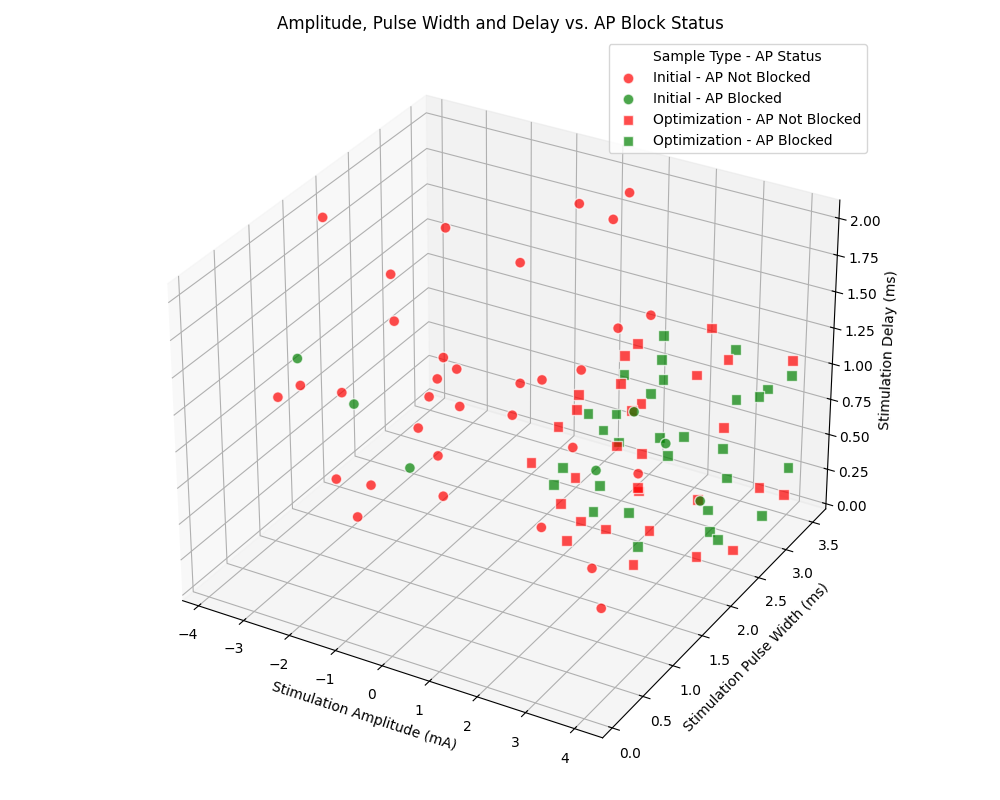

In [69]:
import pandas as pd

# Concatenate all data
all_qp_array = np.vstack(all_qp)
all_observations_array = np.vstack(all_observations).flatten()
all_sample_types_array = np.array(all_sample_types)

# Create DataFrame
df = pd.DataFrame(all_qp_array, columns=['stim_amp', 'stim_pulse', 'stim_delay'])
df['ap_count'] = all_observations_array
df['sample_type'] = all_sample_types_array

# Map 'ap_count' to labels
df['ap_status'] = df['ap_count'].map({0: 'AP Blocked', 1: 'AP Not Blocked'})

# Define markers and colors
markers = {'Initial': 'o', 'Optimization': 's'}
colors = {'AP Not Blocked': 'red', 'AP Blocked': 'green'}

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

for sample_type in df['sample_type'].unique():
    for ap_status in df['ap_status'].unique():
        subset = df[(df['sample_type'] == sample_type) & (df['ap_status'] == ap_status)]
        if not subset.empty:
            ax.scatter(
                subset['stim_amp'],
                subset['stim_pulse'],
                subset['stim_delay'],
                c=colors[ap_status],
                marker=markers[sample_type],
                label=f"{sample_type} - {ap_status}",
                alpha=0.7,
                edgecolors='w',  # Adds white borders to markers for better visibility
                s=60  # Increases marker size for better visibility
            )

# Remove duplicate labels in legend
handles, labels = ax.get_legend_handles_labels()
unique = dict(zip(labels, handles))
ax.legend(unique.values(), unique.keys(), title='Sample Type - AP Status', loc='best')

ax.set_xlabel('Stimulation Amplitude (mA)')
ax.set_ylabel('Stimulation Pulse Width (ms)')
ax.set_zlabel('Stimulation Delay (ms)')
ax.set_title('Amplitude, Pulse Width and Delay vs. AP Block Status')

plt.tight_layout()
plt.show()

In [70]:
df.sort_values(axis=0, by='ap_status').head(10)

df[df['ap_status'] == 'AP Blocked']

,stim_amp,stim_pulse,stim_delay,ap_count,sample_type,ap_status
2,1.316192,2.295995,0.483744,0,Initial,AP Blocked
4,-2.495142,1.225707,0.989784,0,Initial,AP Blocked
6,1.511971,3.366433,0.287915,0,Initial,AP Blocked
7,-2.084665,1.787487,0.367105,0,Initial,AP Blocked
15,3.062799,2.700827,0.279989,0,Initial,AP Blocked
24,1.222992,3.023099,0.617661,0,Initial,AP Blocked
27,-2.790555,0.608489,1.499105,0,Initial,AP Blocked
40,2.844898,3.500000,0.680651,0,Optimization,AP Blocked
42,2.976421,2.448815,0.821791,0,Optimization,AP Blocked
43,3.816251,3.214364,0.948807,0,Optimization,AP Blocked
